In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Kalman Filter

Suppose, the state of a system follows :
$$ 
x_k = Ax_{k-1} + B u_{k-1} + w_{k-1}
$$
where $A$ is the state-transition matrix defining how the state evolve over time, $B$ is the control input matrix that maps the control vector $u_{k-1}$ to the state space, and $w_{k-1}$ is the process noise, assumed to follow a normal distribution: $w_k \sim N(0, Q)$, with covariance matrix $Q$. 

The system is observed through measurements $z_k$, which are related to the latent state via
$$
z_{k} = H x_k + v_k
$$
where $H$ is the observation matrix that  maps the state space to the measurement space and $v_k$, with $v_k \sim N(0, R)$. 

<div style="text-align: center;">
<img src="Kalman_Filter.png" alt="Timeseries" width="500"/>
<\div>

# Local-Level Model

#### State Equation

$$ \mu_t = \mu_{t-1} + \eta_t, \quad \eta_t \sim N(0, \sigma_\eta^2)$$ 

#### Observation Equation

$$ y_t = \mu_t + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, \sigma_\varepsilon^2)$$ 

Here, $A=1$, $H=1$, $Q = \sigma^2_\eta$ and $R = \sigma^2_\varepsilon$

In [2]:
# Simulate data
np.random.seed(42)
T = 100
mu_true = np.zeros(T)
mu_true[0] = 0  # Initial state
sigma_eta = 0.5
sigma_eps = 1.0

for t in range(1, T):
    mu_true[t] = mu_true[t-1] + np.random.normal(0, sigma_eta)

y = mu_true + np.random.normal(0, sigma_eps, T)

A = 1
H = 1
Q = sigma_eta**2
R = sigma_eps**2

In [3]:
# Initial state estimate and covariance
mu_hat = np.zeros(T)
P = np.zeros(T)
mu_hat[0] = 0     #x0
P[0] = 1.0        #P0

for k in range(1, T):
    # 1. Predict the next state
    mu_pred = A * mu_hat[k-1]  # xhat_{k|k-1}
    
    # 2. Predict the error covariance
    P_pred = A * P[k-1] * A + Q  # P_{k|k-1}
    
    # 3. Compute Kalman gain
    K = P_pred * H / (H * P_pred * H + R)  # K_k
    
    # 4. Update state estimate with measurement z_k
    mu_hat[k] = mu_pred + K * (y[k] - H * mu_pred)  # xhat_k
    
    # 5. Update error covariance
    P[k] = (1 - K * H) * P_pred  # P_k

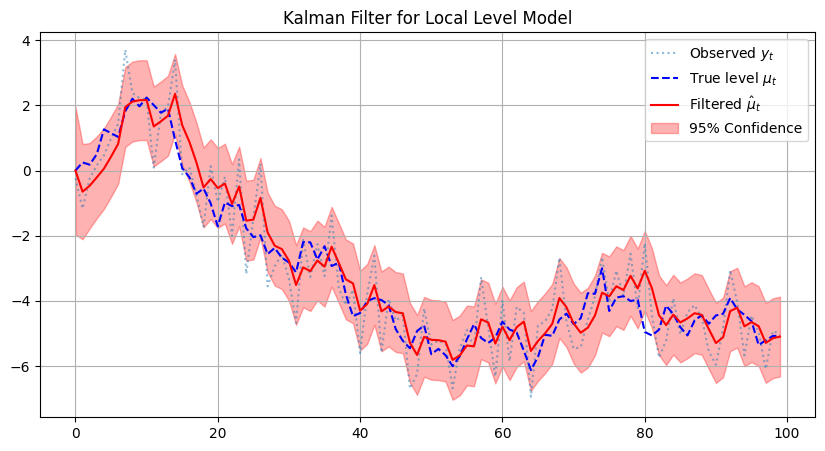

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(y, label='Observed $y_t$', linestyle=':', alpha=0.5)
plt.plot(mu_true, label='True level $\\mu_t$', linestyle='--', color='blue')
plt.plot(mu_hat, label='Filtered $\\hat{\\mu}_t$', color ="red",)
plt.fill_between(range(T), 
                 mu_hat - 1.96*np.sqrt(P), 
                 mu_hat + 1.96*np.sqrt(P), 
                 alpha=0.3, color='red', label='95% Confidence')
plt.title('Kalman Filter for Local Level Model')
plt.legend()
plt.grid(True)
plt.show()

# Local-Level with trend

#### State Equation

\begin{align*}
\mu_k &= \mu_{k-1} + \beta_{k-1} + \eta_k, \quad \quad  \eta_k \sim \mathcal{N}(0, \sigma_\eta^2)\\
\beta_k &= \beta_{k-1} + \zeta_k, \qquad \qquad \quad  \zeta_k \sim \mathcal{N}(0, \sigma_\zeta^2)
\end{align*}


#### Observation Equation:

$$y_k = \mu_k + \varepsilon_k, \quad \varepsilon_k \sim \mathcal{N}(0, \sigma_\varepsilon^2)$$

Notice, 
$$ 
x_k = \begin{bmatrix} \mu_k \\ \beta_k \end{bmatrix},\; A = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix},\; Q = \begin{bmatrix} \sigma_\eta^2 & 0 \\ 0 & \sigma_\zeta^2 \end{bmatrix}, \; H = \begin{bmatrix} 1 & 0 \end{bmatrix}
$$

In [5]:
np.random.seed(42)
T = 100

# True parameters
sigma_eta = 0.2
sigma_zeta = 0.05
sigma_eps = 1.0

# Simulate state and observation
mu = np.zeros(T)
beta = np.zeros(T)
y = np.zeros(T)

for t in range(1, T):
    mu[t] = mu[t-1] + np.random.normal(0, sigma_eta)
    beta[t] = beta[t-1] + np.random.normal(0, sigma_zeta)
    y[t] = mu[t] + beta[t] + np.random.normal(0, sigma_eps)


In [6]:
# Kalman filter 
A = np.array([[1, 1],
              [0, 1]])
H = np.array([[1, 0]])
Q = np.diag([sigma_eta**2, sigma_zeta**2])
R = np.array([[sigma_eps**2]])

# Initialize
x_hat = np.zeros((T, 2))   # Estimates of [mu, beta]
P = np.zeros((T, 2, 2))    # Covariance matrices
x_hat[0] = [0, 0]
P[0] = np.eye(2)

for t in range(1, T):
    # 1. Predict the next state
    x_pred = A @ x_hat[t-1]
    
    # 2. Predict the error covariance
    P_pred = A @ P[t-1] @ A.T + Q

    # 3. Compute Kalman gain
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)

    # 4. Update state estimate with measurement z_k
    x_hat[t] = x_pred + (K @ (y[t] - H @ x_pred)).ravel()
    
    # 5. Update error covariance
    P[t] = (np.eye(2) - K @ H) @ P_pred

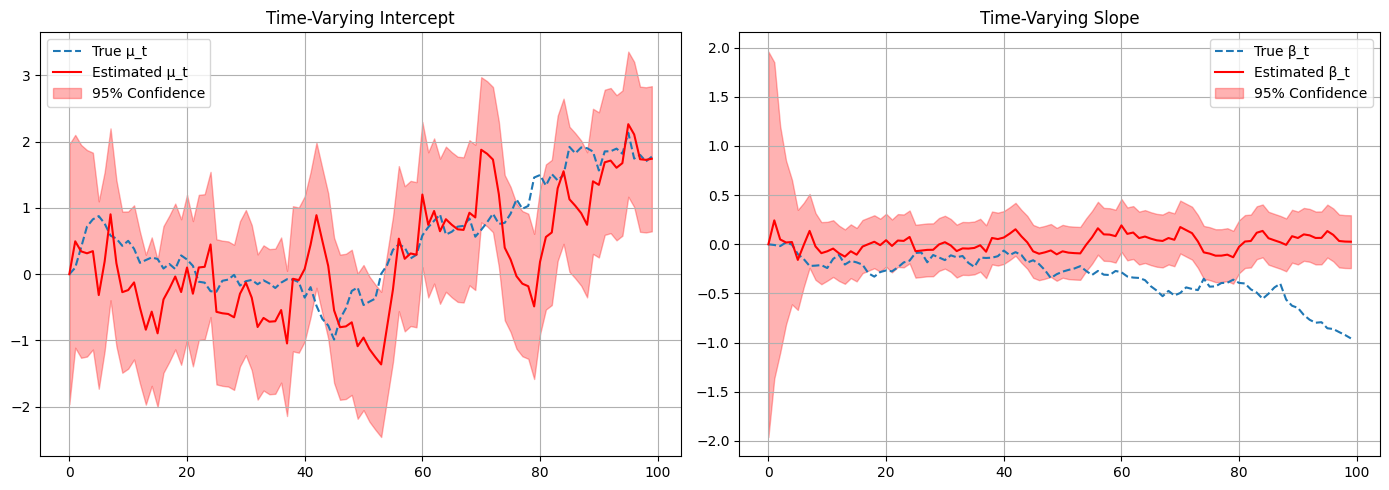

In [7]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(mu, label='True μ_t', linestyle='--')
plt.plot(x_hat[:, 0], label='Estimated μ_t', color='red')
plt.fill_between(range(T), 
                 x_hat[:, 0] - 1.96*np.sqrt(P[:, 0, 0]), 
                 x_hat[:, 0] + 1.96*np.sqrt(P[:, 0, 0]), 
                 alpha=0.3, color='red', label='95% Confidence')
plt.title('Time-Varying Intercept')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(beta, label='True β_t', linestyle='--')
plt.plot(x_hat[:, 1], label='Estimated β_t',color='red')
plt.fill_between(range(T), 
                 x_hat[:, 1] - 1.96*np.sqrt(P[:, 1, 1]), 
                 x_hat[:, 1] + 1.96*np.sqrt(P[:, 1, 1]), 
                 alpha=0.3, color='red', label='95% Confidence')
plt.title('Time-Varying Slope')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Linear Regression with Time-varying paramaters

let, 
$$ y_t = \alpha_t + \beta_t x_t + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, \sigma_\varepsilon^2)$$ 
where, 
$$ \begin{aligned}
\alpha_t &= \alpha_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_\alpha^2) \\
\beta_t &= \beta_{t-1} + \zeta_t, \quad \zeta_t \sim \mathcal{N}(0, \sigma_\beta^2)
\end{aligned}$$

This means, 
$$ x_t = \begin{bmatrix} \alpha_t \\ \beta_t \end{bmatrix}, \; A = I_2, \; Q = \text{diag}(\sigma_\alpha^2, \sigma_\beta^2), \; R = \sigma_\varepsilon^2, \;H = y_t = \begin{bmatrix} 1 & x_t^{(obs)} \end{bmatrix} x_t + \varepsilon_t$$

In [8]:
np.random.seed(42)
T = 100
x_obs = np.linspace(0, 10, T)

# True time-varying coefficients
alpha_true = np.cumsum(np.random.normal(0, 0.1, T))
beta_true = 1 + 0.5 * np.sin(np.linspace(0, 3*np.pi, T))

# Generate observations
y = alpha_true + beta_true * x_obs + np.random.normal(0, 1.0, T)

In [9]:
A = np.eye(2)                      # Transition matrix
Q = np.diag([0.01, 0.01])          # Process noise (for alpha and beta)
R = np.array([[1]])                 # Observation noise
x_hat = np.zeros((T, 2))           # State estimate: [alpha, beta]
P = np.zeros((T, 2, 2))            # State covariance

x_hat[0] = [0, 0]
P[0] = np.eye(2) * 10

for t in range(1, T):
    H_t = np.array([[1, x_obs[t]]])  # Dynamic observation matrix at time t

    # 1. Predict the next state
    x_pred = A @ x_hat[t-1]
    # 2. Predict the error covariance
    P_pred = A @ P[t-1] @ A.T + Q

    # 3. Compute Kalman gain
    K = P_pred @ H_t.T @ np.linalg.inv(H_t @ P_pred @ H_t.T + R)

    y_pred = H_t @ x_pred
    # 4. Update state estimate with measurement z_k
    x_hat[t] = x_pred + (K @ (y[t] - y_pred)).ravel()
    # 5. Update error covariance
    P[t] = (np.eye(2) - K @ H_t) @ P_pred

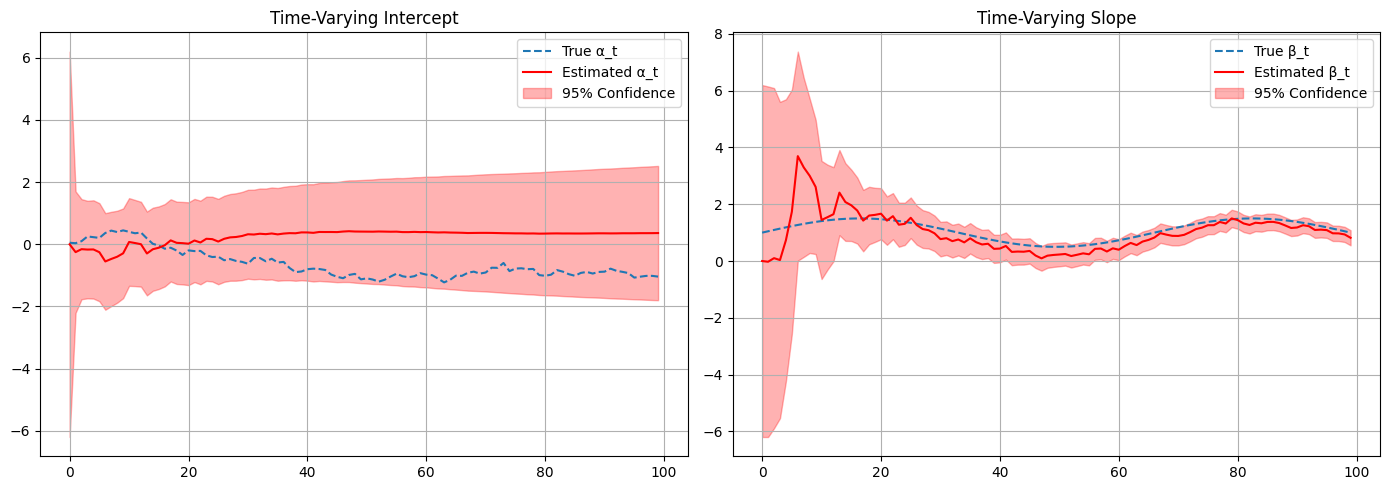

In [10]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(alpha_true, label='True α_t', linestyle='--')
plt.plot(x_hat[:, 0], label='Estimated α_t', color='red')
plt.fill_between(range(T), 
                 x_hat[:, 0] - 1.96*np.sqrt(P[:, 0, 0]), 
                 x_hat[:, 0] + 1.96*np.sqrt(P[:, 0, 0]), 
                 alpha=0.3, color='red', label='95% Confidence')
plt.title('Time-Varying Intercept')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(beta_true, label='True β_t', linestyle='--')
plt.plot(x_hat[:, 1], label='Estimated β_t',color='red')
plt.fill_between(range(T), 
                 x_hat[:, 1] - 1.96*np.sqrt(P[:, 1, 1]), 
                 x_hat[:, 1] + 1.96*np.sqrt(P[:, 1, 1]), 
                 alpha=0.3, color='red', label='95% Confidence')
plt.title('Time-Varying Slope')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Vector Auto Regression with Time-varying Parameters

Let, 
\begin{align}
  y_t \;=\; \nu_t \; + \sum_{j=1}^L A_{j,t} y_{t-j} + \varepsilon_t
\end{align}

where $\varepsilon_t\sim\mathcal{N}(0,\Sigma_t)$ is a zero‐mean Gaussian innovation with potentially time‐varying covariance $\Sigma_t$, $\nu_t$ is a (possibly time‐varying) vector of deterministic terms (e.g. intercepts, trends, seasonal dummies), and. each $A_{j,t}$ is a $K\times K$ matrix of time‐varying autoregressive coefficients governing the effect of the $j$-th lag on $y_t$. 

Define
$$ X_t^\prime = I \otimes (1, y_{t-1}', y_{t-2}', \dots, y_{t-L}') $$ 
where "$\otimes$"  denotes the Kronecker product. Also, let $\theta_t$ be the collection of the VAR's time-varying coeffcients
in vectorized form, that is
$$
\theta_t \equiv vec([\nu_t, A_{1,t}, A_{2,t}, \dots, A_{L,t}]')
$$
Then (1) can be rewritten as, 
$$ 
y_t = X_t'\theta_t + \varepsilon_t
$$
which means we can define
$$
\theta_t = \theta_{t-1} + u_t
$$ 
where $u_t \sim N(0, Q)$. 

In [11]:
def simulate_tvp_var(K=2, p=2, T=200, Q_scale=1e-4, Sigma_scale=0.1, seed=42):
    """
    Simulate a time-varying VAR(p) of dimension K over T periods.
    State:   theta_t = theta_{t-1} + u_t,    u_t ~ N(0, Q)
    Obs eq:  y_t = X_t' theta_t + eps_t,    eps_t ~ N(0, Sigma)
    """
    n_state = K * (1 + K * p)               # length of vec([nu, A1, ..., Ap]')
    
    Q = np.eye(n_state) * Q_scale           # state‐innovation covariance
    Sigma = np.eye(K) * Sigma_scale         # observation noise covariance
    
    theta = np.zeros((T, n_state))
    y     = np.zeros((T, K))
    
    theta[0] = np.zeros(n_state)           
    for t in range(1, p):
        y[t] = np.random.multivariate_normal(np.zeros(K), Sigma)
    
    for t in range(p, T):
        # 1) state evolution
        u_t = np.random.multivariate_normal(np.zeros(n_state), Q)
        theta[t] = theta[t-1] + u_t
        
        # 2) build X_t' = I_K ⊗ [1, y_{t-1}', ..., y_{t-p}']
        x_block = [1.0]  # deterministic intercept
        for lag in range(1, p+1):
            x_block.extend(y[t - lag])
        x_block = np.array(x_block)              # shape: (1 + K*p,)
        
        # X_t' will be a K x (K*(1+K*p)) matrix
        Xt = np.kron(np.eye(K), x_block.reshape(1, -1))
        
        # 3) observation
        eps_t = np.random.multivariate_normal(np.zeros(K), Sigma)
        y[t]  = Xt.dot(theta[t]) + eps_t
    
    return y, theta


K = 2; p = 3; T = 500
y_sim, theta_sim = simulate_tvp_var(K=K, p=p, T=T)

A_sim = np.zeros((T, K, K, p))
for j in range(p):
    start = K + j * K * K  # Start after intercepts + previous A matrices
    end = start + K * K
    block = theta_sim[:, start:end]  # shape (T, K*K)
    A_sim[:, :, :, j] = block.reshape(T, K, K, order='F')

In [12]:
y_sim.shape

(500, 2)

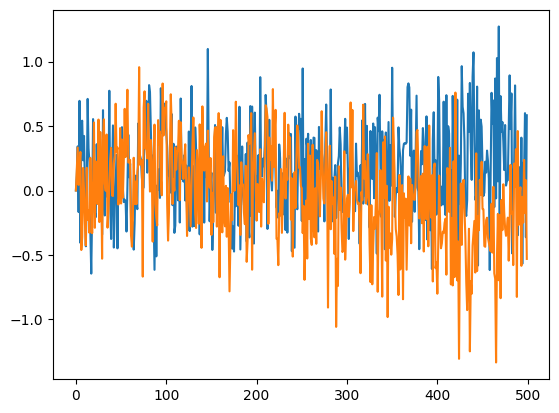

In [13]:
plt.plot(y_sim)

In [14]:
import numpy as np

def tvp_var_kalman(y, K, p, Q, Sigma):
    """
    Kalman‐filter estimate of the TVP‐VAR(p):
      state eq: theta_t = theta_{t-1} + u_t,     u_t ~ N(0,Q)
      obs  eq: y_t     = X_t' theta_t   + eps_t, eps_t~ N(0,Sigma)
    """
    T = y.shape[0]
    n_state = K * (1 + K*p)   # dim of theta_t

    theta_hat = np.zeros((T, n_state))
    P         = np.zeros((T, n_state, n_state))

    # Initial guesses
    theta_hat[0] = np.zeros(n_state)       
    P[0]         = np.eye(n_state) * 10.0  

    I_n = np.eye(n_state)

    for t in range(1, T):
        # 1) Build observation matrix H_t
        if t >= p:
            x_block = [1.0] + list(np.hstack([y[t - lag] for lag in range(1, p+1)]))
        else:
            # Partial lags: pad with zeros for missing lags
            x_block = [1.0]
            for lag in range(1, p+1):
                if t - lag >= 0:
                    x_block.extend(y[t - lag])
                else:
                    x_block.extend([0.0] * K)  
        
        x_block = np.array(x_block)            # shape (1 + K*p,)
        H_t = np.kron(np.eye(K), x_block.reshape(1, -1))  # (K × n_state)

        # 2) Predict step
        theta_pred = theta_hat[t-1]            # random walk: F = I
        P_pred     = P[t-1] + Q

        # 3) Update step
        S = H_t @ P_pred @ H_t.T + Sigma       # innovation cov
        K_gain = P_pred @ H_t.T @ np.linalg.inv(S)

        resid = y[t] - (H_t @ theta_pred)      
        theta_hat[t] = theta_pred + K_gain @ resid
        P[t]         = (I_n - K_gain @ H_t) @ P_pred

    return theta_hat, P

In [15]:
K, p, T = 2, 3, 500
Q_true     = np.eye(K*(1+K*p)) * 1e-4  
Sigma_true = np.eye(K) * 0.1

theta_hat, P = tvp_var_kalman(y_sim, K, p, Q_true, Sigma_true)

A_hat = np.zeros((T, K, K, p))
for t in range(T):
    for j in range(p):
        start = K + j*(K*K)  
        coef_vec = theta_hat[t][start : start + K*K]
        A_hat[t, :, :, j] = coef_vec.reshape(K, K, order='F')

In [16]:
def plot_coef(ax, j, r, c, color, A_sim, A_hat, P, plot_start=0):
    """
    plot True vs Est + 95% CI for A_{j+1,t}[r,c].
    j = lag‐index (0→A1, 1→A2, …)
    r,c = row/col in the 2×2 coefficient matrix
    """
    # compute the position in theta vector
    # State ordering: [intercepts for each eq] then [A1 entries], then [A2], …
    # intercepts occupy the first K slots, then each Aj has K^2 slots
    coef_idx = K + j*(K*K) + c*K + r  

    true_path = A_sim[plot_start:, r, c, j]
    est_path  = A_hat[plot_start:, r, c, j]
    stderr    = np.sqrt(P[plot_start:, coef_idx, coef_idx])

    ax.plot(time_axis, true_path,   linestyle='--', color='k',     label=f'True $A_{{{j+1},t}}[{r},{c}]$')
    ax.plot(time_axis, est_path,    color=color, alpha=0.8,       label=f'Est.  $A_{{{j+1},t}}[{r},{c}]$')
    ax.fill_between(time_axis,
                    est_path - 1.96*stderr,
                    est_path + 1.96*stderr,
                    color=color, alpha=0.3,
                    label='95% C.I.')
    ax.set_title(f'$A_{{{j+1},t}}[{r},{c}]$ over time')
    ax.grid(True)
    ax.legend()

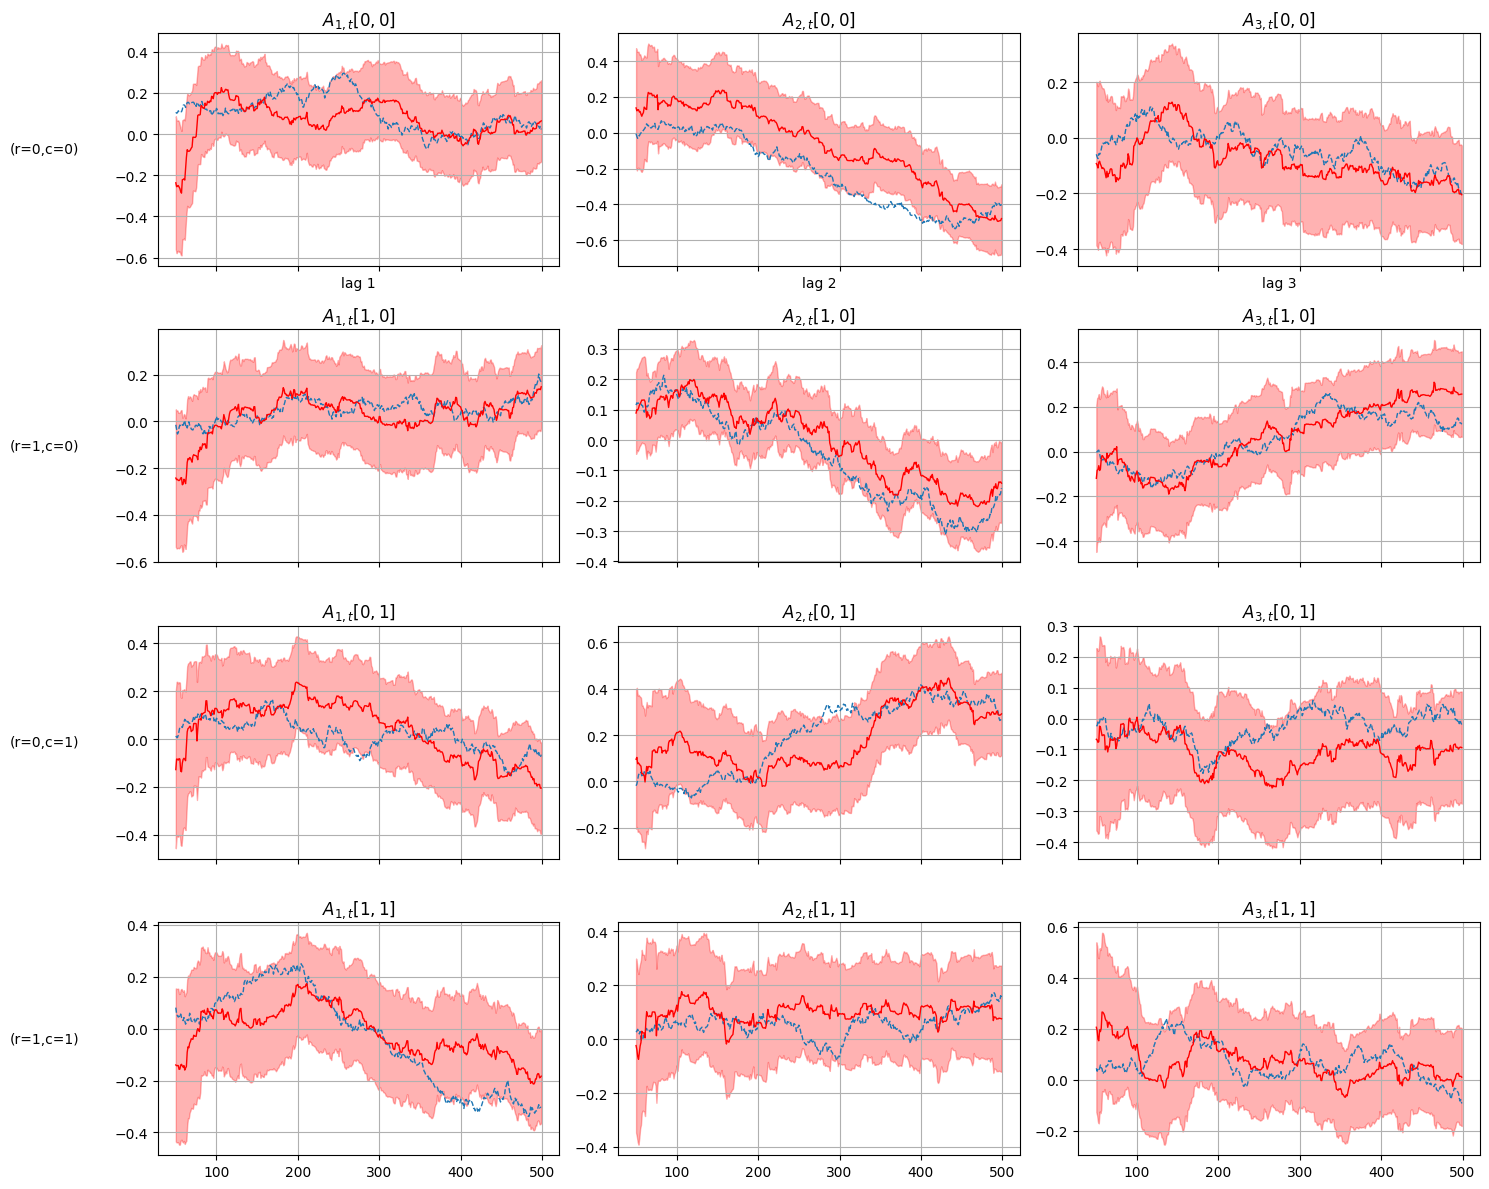

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_coef(ax, j, r, c, A_sim, A_hat, P, start_index=0):
    """
    Plot True vs Est + 95% CI for A_{j+1,t}[r,c], skipping the first start_index obs.
    j = lag‐index (0→A1, 1→A2, …)
    r,c = row/col in the K×K coefficient matrix
    """
    coef_idx = K + j*(K*K) + c*K + r  # match your state‐vector ordering
    t0 = start_index
    time_axis = np.arange(t0, T)

    true_path = A_sim[t0:, r, c, j]
    est_path  = A_hat[t0:, r, c, j]
    stderr    = np.sqrt(P[t0:, coef_idx, coef_idx])

    ax.plot(time_axis, true_path, linestyle='--', lw=1, label=f'True $A_{{{j+1},t}}[{r},{c}]$')
    ax.plot(time_axis, est_path, color='r', lw=1, label=f'Est.  $A_{{{j+1},t}}[{r},{c}]$')
    ax.fill_between(time_axis,
                    est_path - 1.96*stderr,
                    est_path + 1.96*stderr,
                    color='r', alpha=0.3, label='95% C.I.')
    ax.set_title(f'$A_{{{j+1},t}}[{r},{c}]$')
    ax.grid(True)
    # only show one legend
    #if (j, r, c) == (0, 0, 0):
        #ax.legend(fontsize='small')

fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharex=True)
skip = 50  # number of initial obs to skip
for r in range(K):
    for c in range(K):
        for j in range(p):
            row = r + c*K
            col = j
            plot_coef(axes[row, col], j, r, c,
                      A_sim=A_sim, A_hat=A_hat, P=P,
                      start_index=skip)

# label rows & cols if desired
row_labels = ["(r=0,c=0)", "(r=1,c=0)", "(r=0,c=1)", "(r=1,c=1)"]
for i, lab in enumerate(row_labels):
    axes[i,0].set_ylabel(lab, rotation=0, labelpad=50, va='center')
for j in range(p):
    axes[0,j].set_xlabel(f'lag {j+1}')

plt.tight_layout()